In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import math
from matplotlib import pyplot as plt
from dataclasses import dataclass
import time
import pandas as pd

In [2]:
@dataclass
class Args:
    # file_path = 'data/TinyStories-valid.txt'
    # tokenizer_path = "tokenizer.model"
    # frequency_cutoff=25

    batch_size: int = 32
    context_window: int = 16
    # early_stopping_criteria :int = 5
    # learning_rate: float = 0.001
    n_layers: int = 32
    n_heads: int = 8
    vocab_size: int = -1  # set after tokenizer is loaded
    d_model: int = 128
    epochs: int = 100
    log_interval: int = 10
    max_seq_len: int = 512
    # device: str = "cuda" if torch.cuda.is_available() else "cpu"
    # cuda: bool = True

    def __repr__(self) -> str:
        # print all the attributes of the class and theirn values
        return '\n'.join([f'{k} : {v}' for k, v in self.__dict__.items()])
    
    def __str__(self) -> str:
        return self.__repr__()
Args = Args()

In [3]:
Args

batch_size : 32
context_window : 16
n_layers : 32
n_heads : 8
vocab_size : -1
d_model : 128
epochs : 100
log_interval : 10
max_seq_len : 512

In [4]:
lines = open('./data/TinyStories-valid.txt', encoding="utf8").read()
lines = lines[:1115394]
vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

print(lines[:30])

 Spot. Spot saw the shiny car 


In [5]:
# simple tokenization by characters
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])

print('vocab size:', len(vocab))
decode(encode("hello"))

vocab size: 83


'hello'

In [6]:
dataset = torch.tensor(encode(lines), dtype=torch.int8)
dataset.shape

torch.Size([1115394])

In [7]:
def get_batches(data, split, batch_size, context_window, config=Args):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    batch_data = train
    if split == 'val':
        batch_data = val

    if split == 'test':
        batch_data = test

    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y


In [8]:
@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model, config=Args):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config.batch_size, config.context_window, config=config)
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

In [9]:


class SimpleBrokenModel(nn.Module):
    def __init__(self, config=Args):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config.vocab_size, config.d_model)
        self.linear = nn.Sequential(
            nn.Linear(config.d_model, config.d_model),
            nn.ReLU(),
            nn.Linear(config.d_model, config.vocab_size),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)
        # logits = F.softmax(a, dim=-1)

        if targets is not None:
            loss = loss = F.cross_entropy(logits.view(-1, self.config.vocab_size), targets.view(-1))
            return logits, loss

        else:
            return logits

Args.d_model = 128


# model = SimpleBrokenModel(Args)
# xs, ys = get_batches(dataset, 'train', Args.batch_size, Args.context_window)

# logits, loss = model(xs, ys)

model params: 37843


d:\Codes\Environments\torch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


validation loss:  2.298335576057434


<Axes: >

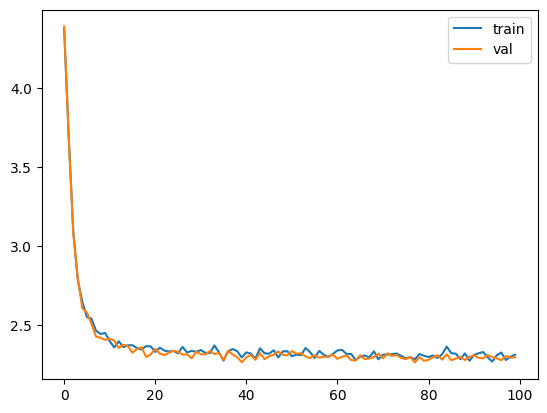

In [10]:

Args.vocab_size = len(vocab)
Args.batch_size = 32
Args.context_window = 16
Args.epochs = 1000
Args.log_interval = 10




model = SimpleBrokenModel(Args)

optimizer = torch.optim.Adam(
    model.parameters(), 
)

def train(model, optimizer, scheduler=None, config=Args, print_logs=False):
    losses = []
    start_time = time.time()
    for epoch in range(config.epochs):
        optimizer.zero_grad()

        xs, ys = get_batches(dataset, 'train', config.batch_size, config.context_window)
        logits, loss = model(xs, targets=ys)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        if epoch % config.log_interval == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())

    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

train(model, optimizer)

In [11]:
def generate(model, config=Args, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config.context_window:])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [decode(x) for x in idx.tolist()]

generate(model)

['\nLind bllinf whe f Dor sag aled',
 "\nMang cuthe tottan'my was y fid",
 '\nLimilothed Lit ugandid ined a ',
 '\n<|>\n<|>\nSu p my, \nJowind. gan ',
 '\nThr d He amen wastow s fur tox']

### RMS-Norm

In [12]:
# The OG RMS Norm form the llama inference repo 
class RMSNorm(nn.Module):
    def __init__(self, dim:int, eps:float = 1e-8):
        super().__init__()
        self.eps = eps

        self.weight = nn.Parameter(torch.ones(dim))
    
    def _norm(self, x:torch.Tensor):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True))#+self.eps)
    
    def forward(self, x:torch.Tensor):
        # print(self.weight.shape, x.shape, self._norm(x.float()).shape)
        return self.weight * self._norm(x.float()).type_as(x)

# class RMSNorm_second(nn.Module):
#     def __init__(self, layer_shape, eps=1e-8, bias=False):
#         super(RMSNorm, self).__init__()
#         self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

#     def forward(self, x):
#         """
#         assumes shape is (batch, seq_len, d_model)
#         """
#         # frob norm is not the same as RMS. RMS = 1/sqrt(N) * frob norm
#         ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
#         raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
#         return self.scale[:x.shape[1], :].unsqueeze(0) * raw

In [13]:
# torch.manual_seed(18)

# class SimpleModel_RMS(nn.Module):
#     def __init__(self, config):
#         super().__init__()
#         self.config = config

#         self.embedding = nn.Embedding(config.vocab_size, config.d_model)
#         self.rms = RMSNorm((config.d_model))
#         self.linear = nn.Sequential(
#             nn.Linear(config.d_model, config.d_model),
#             nn.ReLU(),
#             nn.Linear(config.d_model, config.vocab_size),
#         )

#         print("model params:", sum([m.numel() for m in self.parameters()]))

#     def forward(self, idx, targets=None):
#         x = self.embedding(idx)
#         x = self.rms(x) # rms pre-normalization
#         logits = self.linear(x)

#         if targets is not None:
#             loss = F.cross_entropy(logits.view(-1, self.config.vocab_size), targets.view(-1))
#             return logits, loss

#         else:
#             return logits

# model = SimpleModel_RMS(Args)
# xs, ys = get_batches(dataset, 'train', Args.batch_size, Args.context_window)

# logits, loss = model(xs, ys)
# optimizer = torch.optim.Adam(model.parameters())
# train(model, optimizer)

### ROPE -> Rotary Positional Embeddings Positional Embeddings

In [14]:
def precompute_theta_pos_frequencies(head_dim: int, seq_len: int, device: str, theta: float = 10000.0):
    assert head_dim % 2 == 0

    theta_numerator = torch.arange(0, head_dim, 2).float()
    # shape (head_dim /2)
    theta = 1.0 / (theta ** (theta_numerator/head_dim)).to(device)
    m = torch.arange(seq_len, device=device)
    # multiply each theta by each position using the outer product
    # shape: seqlen outer prodcut head_dim / 2 -> (seq_len, head_dim /2)
    freqs = torch.outer(m, theta).float()
    freqs_complex = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_complex

def apply_rotary_embeddings(x: torch.Tensor, freqs_complex: torch.Tensor, device: str):
    
    # print(f"X-Shape: {x.shape}")
    # print(f"Freqs-Shape: {freqs_complex.shape}")
    
    cntxt_length = x.shape[1]
    
    # print(f"Context-Length: {context_length}")
    
    # (B, Seq_len, H, Head_dim) -> (B, Seq_len, H, Head_dim / 2)
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1 ,2))
    
    # print(f"X-Complex-Shape: {x_complex.shape}")
    
    # seq_len, Head_dim/2 -> (1, Seq_len, 1, Head_dim / 2)
    freqs_complex = freqs_complex[:cntxt_length,:]
    
    # print(f"Freqs-Complex-Limited-Shape: {freqs_complex_limited.shape}")
    
    freqs_complex = freqs_complex.unsqueeze(0).unsqueeze(2)
    
    # print(f"Freqs-Complex-Shape-After-Unsqueeze: {freqs_complex.shape}")

    # (B, Seq_len, H, Head_dim /2) * (1, Seq_len, 1, Head_dim / 2) = (B, Seq_len, H, Head_dim / 2)
    x_rotated = x_complex * freqs_complex
    
    # print(f"X-Rotated-Shape: {x_rotated.shape}")
    
    # (B,seq_len, H, Head_dim/2) -> (B, Seq_len, H, Head_dim/2, 2)
    x_out = torch.view_as_real(x_rotated)

    # print(f"X-Out-Shape: {x_out.shape}")
    # print(f"Reshape X-out to x:{x.shape}")
    
    # (B, seq_len, H, Head_dim/2, 2 ) -> (B, sseq_len, H, Head_dim)
    x_out = x_out.reshape(*x.shape)
    return x_out.type_as(x).to(device)

In [15]:

class SelfAttention(nn.Module):
    def __init__(self, args):
        super().__init__()

        self.n_heads = args.n_heads

        self.n_rep = self.n_heads // self.n_heads
        self.head_dim = args.d_model // args.n_heads

        self.wq = nn.Linear(args.d_model, args.n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(args.d_model, self.n_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(args.d_model, self.n_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(args.n_heads*self.head_dim, args.d_model, bias=False)


    def forward(self, x:torch.Tensor, freqs_complex:torch.Tensor):
        batch_size, seq_len, _ = x.shape  # (B, 1, Dim)

        # (B, 1, Dim) -> (B, 1, H_Q * Head_Dim)
        xq = self.wq(x)
        # (B, 1, Dim) -> (B, 1, H_KV * Head_Dim)
        xk = self.wk(x)
        # (B, 1, Dim) -> (B, 1, H_KV * Head_Dim)
        xv = self.wv(x)
        print(f"XQ-Shape: {xq.shape}")
        print(f"XK-Shape: {xk.shape}")
        # (B, 1, H_Q * Head_Dim) -> (B, 1, H_Q, Head_Dim)
        xq = xq.view(batch_size, seq_len, self.n_heads, self.head_dim)
        # (B, 1, H_KV * Head_Dim) -> (B, 1, H_KV, Head_Dim)
        xk = xk.view(batch_size, seq_len, self.n_heads, self.head_dim)
        # (B, 1, H_KV * Head_Dim) -> (B, 1, H_KV, Head_Dim)
        xv = xv.view(batch_size, seq_len, self.n_heads, self.head_dim)

        print(f"XQ-Shape: {xq.shape}")
        print(f"XK-Shape: {xk.shape}")
        #apply rotatory embeddings to the keys and values
        xq = apply_rotary_embeddings(xq, freqs_complex, x.device)
        xk = apply_rotary_embeddings(xk, freqs_complex, x.device)

        #! Do we need to do something here ?
        #! Previously we had Key value caching here and were repeating number of heads

        # activations = F.scaled_dot_product_attention(
        #     xq,xk,xv,dropout_p =.1
        # )

        # return activations

        xq = xq.transpose(1,2)
        keys = xk.transpose(1,2)
        values = xv.transpose(1,2)

        scores = torch.matmul(xq, keys.transpose(2,3)) / math.sqrt(self.head_dim)
        scores = F.softmax(scores.float(), dim=-1).type_as(xq)

        output = torch.matmul(scores, values)
        output = output.transpose(1,2).contiguous().view(batch_size, seq_len, -1)
        return self.wo(output)

# layer = SelfAttention(Args)
# batch = torch.randn((Args.batch_size, Args.context_window, Args.d_model))
# freqs_complex = precompute_theta_pos_frequencies(Args.d_model // Args.n_heads, Args.context_window, device = "cpu")
# output= layer(batch, freqs_complex)

model params: 103507
Running first norm
computing rope attention
XQ-Shape: torch.Size([32, 16, 128])
XK-Shape: torch.Size([32, 16, 128])
XQ-Shape: torch.Size([32, 16, 8, 16])
XK-Shape: torch.Size([32, 16, 8, 16])
X-Shape: torch.Size([32, 16, 8, 16])
Freqs-Shape: torch.Size([16, 8])
X-Complex-Shape: torch.Size([32, 16, 8, 8])
Freqs-Complex-Shape-After-Unsqueeze: torch.Size([1, 16, 1, 8])
X-Rotated-Shape: torch.Size([32, 16, 8, 8])
X-Out-Shape: torch.Size([32, 16, 8, 8, 2])
Reshape X-out to x:torch.Size([32, 16, 8, 16])
X-Shape: torch.Size([32, 16, 8, 16])
Freqs-Shape: torch.Size([16, 8])
X-Complex-Shape: torch.Size([32, 16, 8, 8])
Freqs-Complex-Shape-After-Unsqueeze: torch.Size([1, 16, 1, 8])
X-Rotated-Shape: torch.Size([32, 16, 8, 8])
X-Out-Shape: torch.Size([32, 16, 8, 8, 2])
Reshape X-out to x:torch.Size([32, 16, 8, 16])
running second norm
Pass completed
Running first norm
computing rope attention
XQ-Shape: torch.Size([32, 16, 128])
XK-Shape: torch.Size([32, 16, 128])
XQ-Shape: torc

<Axes: >

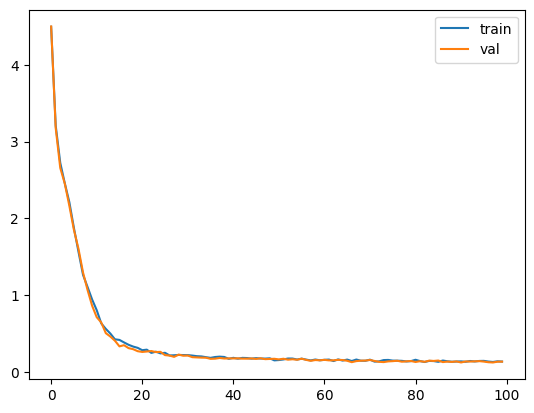

In [16]:
Args.vocab_size = len(vocab)
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config.vocab_size, config.d_model)
        self.rms = RMSNorm((config.d_model))
        self.rope_attention = SelfAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config.d_model, config.d_model),
            nn.ReLU(),
        )

        self.last_linear = nn.Linear(config.d_model, config.vocab_size)
        self.freqs_complex = precompute_theta_pos_frequencies(Args.d_model // Args.n_heads, Args.context_window, device = "cpu")

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        # print(idx.shape)
        x = self.embedding(idx)
        # print(x.shape)
        print("Running first norm")
        # one block of attention
        x = self.rms(x) # rms pre-normalization
        # print(x.shape)
        print("computing rope attention")
        x = x + self.rope_attention(x, self.freqs_complex)
        print("running second norm")
        x = self.rms(x) # rms pre-normalization
        x = x + self.linear(x)

        logits = self.last_linear(x)
        print("Pass completed")
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config.vocab_size), targets.view(-1))
            return logits, loss

        else:
            return logits

model = RopeModel(Args)
xs, ys = get_batches(dataset, 'train', Args.batch_size, Args.context_window)

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

In [17]:
Args

batch_size : 32
context_window : 16
n_layers : 32
n_heads : 8
vocab_size : 83
d_model : 128
epochs : 1000
log_interval : 10
max_seq_len : 512

In [18]:
def generate(model, config=Args, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config.context_window:])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [decode(x) for x in idx.tolist()]

generate(model)

Running first norm
computing rope attention
XQ-Shape: torch.Size([5, 1, 128])
XK-Shape: torch.Size([5, 1, 128])
XQ-Shape: torch.Size([5, 1, 8, 16])
XK-Shape: torch.Size([5, 1, 8, 16])
X-Shape: torch.Size([5, 1, 8, 16])
Freqs-Shape: torch.Size([16, 8])
X-Complex-Shape: torch.Size([5, 1, 8, 8])
Freqs-Complex-Shape-After-Unsqueeze: torch.Size([1, 1, 1, 8])
X-Rotated-Shape: torch.Size([5, 1, 8, 8])
X-Out-Shape: torch.Size([5, 1, 8, 8, 2])
Reshape X-out to x:torch.Size([5, 1, 8, 16])
X-Shape: torch.Size([5, 1, 8, 16])
Freqs-Shape: torch.Size([16, 8])
X-Complex-Shape: torch.Size([5, 1, 8, 8])
Freqs-Complex-Shape-After-Unsqueeze: torch.Size([1, 1, 1, 8])
X-Rotated-Shape: torch.Size([5, 1, 8, 8])
X-Out-Shape: torch.Size([5, 1, 8, 8, 2])
Reshape X-out to x:torch.Size([5, 1, 8, 16])
running second norm
Pass completed
Running first norm
computing rope attention
XQ-Shape: torch.Size([5, 2, 128])
XK-Shape: torch.Size([5, 2, 128])
XQ-Shape: torch.Size([5, 2, 8, 16])
XK-Shape: torch.Size([5, 2, 8, 16

['\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n']

In [19]:
idx = torch.zeros(5, 1).long()
model_input = idx[:, -Args.context_window:]
model_input.shape

torch.Size([5, 1])

In [20]:
5*8*16

640

In [21]:
Args.context_window

16